In [1]:
import pandas as pd

df = pd.read_csv('../data/twitter_dataset.csv')
print(df.columns)
df.head()

Index(['clean_text', 'category'], dtype='object')


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Fix SSL certificate issues (common on macOS)
import ssl
import urllib.request
import certifi

# Create SSL context with proper certificates
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: []


In [5]:
def load_imdb_data():
    """Load IMDB data with multiple fallback options"""
    try:
        # Option 1: Try loading IMDB dataset directly
        print("Attempting to load IMDB dataset...")
        imdb = tf.keras.datasets.imdb
        (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
        word_index = imdb.get_word_index()
        return x_train, y_train, x_test, y_test, word_index, "imdb"
    except Exception as e:
        print(f"Failed to load IMDB dataset: {e}")
        print("Trying alternative methods...")
        
        # Option 2: Create synthetic data for testing
        print("Creating synthetic sentiment data for testing...")
        return create_synthetic_data()

def create_synthetic_data():
    """Create synthetic sentiment data for testing purposes"""
    # Sample positive and negative reviews
    positive_texts = [
        "This movie was absolutely fantastic and amazing",
        "I loved every minute of this incredible film",
        "Outstanding performance by all the actors",
        "Brilliant storyline and excellent direction",
        "Highly recommend this masterpiece to everyone",
        "Perfect blend of action and emotion",
        "The best movie I have ever seen",
        "Wonderful cinematography and great music",
        "Exceptional acting and compelling plot",
        "This film exceeded all my expectations"
    ] * 100  # Repeat to create more samples
    
    negative_texts = [
        "This movie was terrible and boring",
        "Waste of time and money, very disappointing",
        "Poor acting and weak storyline",
        "Completely predictable and uninteresting",
        "The worst film I have ever watched",
        "Terrible direction and bad script",
        "Boring plot with no character development",
        "Poorly executed and uninspiring",
        "Disappointing performance by the actors",
        "Avoid this movie at all costs"
    ] * 100  # Repeat to create more samples
    
    # Create labels
    labels = [1] * len(positive_texts) + [0] * len(negative_texts)
    texts = positive_texts + negative_texts
    
    # Tokenize
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    return x_train, y_train, x_test, y_test, tokenizer.word_index, "synthetic"

# Load data
x_train, y_train, x_test, y_test, word_index, data_type = load_imdb_data()

print(f"Data type: {data_type}")
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")
print(f"Number of unique words: {len(word_index)}")

# Function to decode reviews (works for both IMDB and synthetic data)
def decode_review(text, word_index, data_type):
    if data_type == "imdb":
        reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
        return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    else:
        reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
        return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Display example
if len(x_train) > 0:
    print(f"Example review: {decode_review(x_train[0], word_index, data_type)}")
    print(f"Label: {y_train[0]}")

Attempting to load IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step
Data type: imdb
Training samples: 25000
Testing samples: 25000
Number of unique words: 88584
Example review: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they wer

In [6]:
max_length = 100  # Reduced for synthetic data, increase to 500 for real IMDB data

# Convert to numpy arrays if needed
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Max sequence length: {max_length}")

# Check data distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training label distribution: {dict(zip(unique, counts))}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"Testing label distribution: {dict(zip(unique, counts))}")

Training data shape: (25000, 100)
Testing data shape: (25000, 100)
Max sequence length: 100
Training label distribution: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}
Testing label distribution: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


In [7]:
max_length = 100  # Reduced for synthetic data, increase to 500 for real IMDB data

# Convert to numpy arrays if needed
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Max sequence length: {max_length}")

# Check data distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training label distribution: {dict(zip(unique, counts))}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"Testing label distribution: {dict(zip(unique, counts))}")

Training data shape: (25000, 100)
Testing data shape: (25000, 100)
Max sequence length: 100
Training label distribution: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}
Testing label distribution: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


In [8]:
"""
# If you have a CSV file with 'text' and 'sentiment' columns
df = pd.read_csv('sentiment_data.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df['sentiment'].value_counts())

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences
max_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare labels
label_mapping = {'positive': 1, 'negative': 0}  # Adjust based on your labels
y = df['sentiment'].map(label_mapping)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)
"""

'\n# If you have a CSV file with \'text\' and \'sentiment\' columns\ndf = pd.read_csv(\'sentiment_data.csv\')\nprint(f"Dataset shape: {df.shape}")\nprint(df.head())\nprint(df[\'sentiment\'].value_counts())\n\n# Text preprocessing function\ndef preprocess_text(text):\n    # Convert to lowercase\n    text = text.lower()\n    # Remove punctuation\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    # Remove extra whitespace\n    text = \' \'.join(text.split())\n    return text\n\n# Apply preprocessing\ndf[\'cleaned_text\'] = df[\'text\'].apply(preprocess_text)\n\n# Tokenization\ntokenizer = Tokenizer(num_words=10000, oov_token=\'<OOV>\')\ntokenizer.fit_on_texts(df[\'cleaned_text\'])\nsequences = tokenizer.texts_to_sequences(df[\'cleaned_text\'])\n\n# Pad sequences\nmax_length = 500\npadded_sequences = pad_sequences(sequences, maxlen=max_length, padding=\'post\', truncating=\'post\')\n\n# Prepare labels\nlabel_mapping = {\'positive\': 1, \'negative\': 0}  # Adjust

In [9]:
def create_lstm_model(vocab_size, embedding_dim, max_length, lstm_units=64):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # Spatial dropout for regularization
        SpatialDropout1D(0.2),
        
        # LSTM layer with dropout
        LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Model parameters
vocab_size = 10000
embedding_dim = 100
lstm_units = 64

# Create model
model = create_lstm_model(vocab_size, embedding_dim, max_length, lstm_units)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Model checkpoint to save best model
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks = [early_stopping, checkpoint]

In [12]:
print("Starting training...")
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5888 - loss: 0.6635

782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - accuracy: 0.5890 - loss: 0.6633 - val_accuracy: 0.6568 - val_loss: 0.7066
Epoch 2/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7066 - loss: 0.5814

782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.7067 - loss: 0.5813 - val_accuracy: 0.7755 - val_loss: 0.5063
Epoch 3/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8047 - loss: 0.4612

782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.8047 - loss: 0.4612 - val_accuracy: 0.8044 - val_loss: 0.4377
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.8658 - loss: 0.3486 - val_accuracy: 0.8044 - val_loss: 0.4279
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.8989 - loss: 0.2759 - val_accuracy: 0.7964 - val_loss: 0.4564
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.9232 - loss: 0.2260 - val_accuracy: 0.7987 - val_loss: 0.5156
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.9464 - loss: 0.1680 - val_accuracy: 0.7967 - val_loss: 0.6093
Training completed!


In [13]:
model.load_weights('best_lstm_model.h5')

# Make predictions
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Test Accuracy: 0.8044

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.80     12500
    Positive       0.80      0.81      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



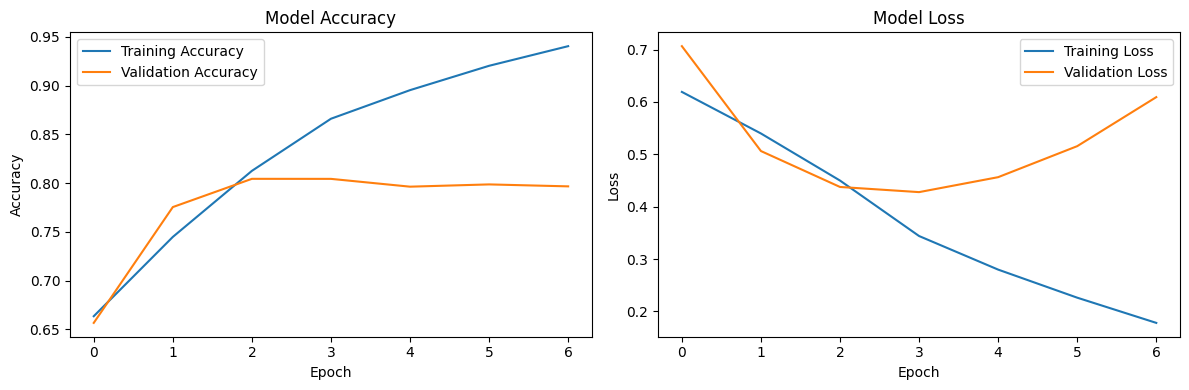

In [14]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

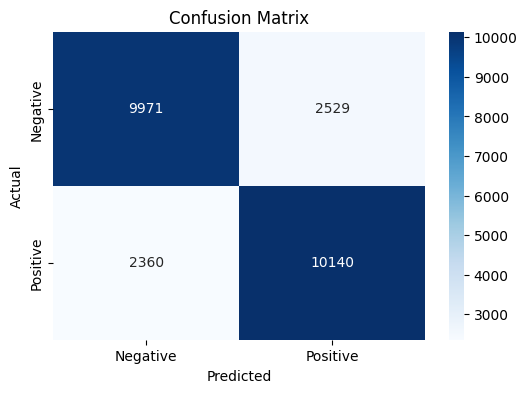

In [15]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
def predict_sentiment(text, model, word_index, data_type, max_length=100):
    """
    Predict sentiment of new text
    """
    # Preprocess text
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    
    # Convert to sequence
    sequence = []
    
    if data_type == "imdb":
        # For IMDB dataset, add offset of 3 for reserved indices
        for word in words:
            if word in word_index:
                sequence.append(word_index[word] + 3)
            else:
                sequence.append(2)  # OOV token
    else:
        # For synthetic/custom data
        for word in words:
            if word in word_index:
                sequence.append(word_index[word])
            else:
                sequence.append(1)  # OOV token
    
    # Pad sequence
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction = model.predict(sequence, verbose=0)[0][0]
    
    # Interpret result
    if prediction > 0.5:
        return f"Positive sentiment (confidence: {prediction:.3f})"
    else:
        return f"Negative sentiment (confidence: {1-prediction:.3f})"

def predict_batch_sentiment(texts, model, word_index, data_type, max_length=100):
    """
    Predict sentiment for multiple texts at once
    """
    sequences = []
    
    for text in texts:
        # Preprocess text
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = text.split()
        
        # Convert to sequence
        sequence = []
        
        if data_type == "imdb":
            for word in words:
                if word in word_index:
                    sequence.append(word_index[word] + 3)
                else:
                    sequence.append(2)  # OOV token
        else:
            for word in words:
                if word in word_index:
                    sequence.append(word_index[word])
                else:
                    sequence.append(1)  # OOV token
        
        sequences.append(sequence)
    
    # Pad sequences
    sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    
    # Make predictions
    predictions = model.predict(sequences, verbose=0)
    
    results = []
    for i, pred in enumerate(predictions):
        confidence = pred[0]
        if confidence > 0.5:
            results.append({
                'text': texts[i],
                'sentiment': 'Positive',
                'confidence': confidence
            })
        else:
            results.append({
                'text': texts[i],
                'sentiment': 'Negative',
                'confidence': 1 - confidence
            })
    
    return results

In [18]:
sample_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible film, waste of time and money.",
    "It was okay, nothing special but not bad either.",
    "Outstanding performance by the actors, highly recommend!",
    "Boring and predictable plot, very disappointed.",
    "Amazing cinematography and brilliant storytelling.",
    "The worst movie I have ever seen in my life.",
    "Good movie with decent acting and plot.",
    "Excellent direction and superb character development.",
    "Completely boring and uninspiring film."
]

print("Testing sentiment predictions:")
print("=" * 60)

# Test individual predictions
for i, text in enumerate(sample_texts[:5], 1):
    result = predict_sentiment(text, model, word_index, data_type, max_length)
    print(f"{i}. Text: {text}")
    print(f"   Prediction: {result}")
    print("-" * 60)

print("\nBatch predictions:")
print("=" * 60)

# Test batch predictions
batch_results = predict_batch_sentiment(sample_texts, model, word_index, data_type, max_length)
for i, result in enumerate(batch_results, 1):
    print(f"{i}. {result['sentiment']} ({result['confidence']:.3f}): {result['text'][:50]}...")

Testing sentiment predictions:
1. Text: This movie was absolutely fantastic! I loved every minute of it.
   Prediction: Positive sentiment (confidence: 0.973)
------------------------------------------------------------
2. Text: Terrible film, waste of time and money.
   Prediction: Negative sentiment (confidence: 0.721)
------------------------------------------------------------
3. Text: It was okay, nothing special but not bad either.
   Prediction: Negative sentiment (confidence: 0.647)
------------------------------------------------------------
4. Text: Outstanding performance by the actors, highly recommend!
   Prediction: Positive sentiment (confidence: 0.973)
------------------------------------------------------------
5. Text: Boring and predictable plot, very disappointed.
   Prediction: Negative sentiment (confidence: 0.603)
------------------------------------------------------------

Batch predictions:
1. Positive (0.973): This movie was absolutely fantastic! I loved ever

In [19]:
def create_advanced_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # Spatial dropout
        SpatialDropout1D(0.3),
        
        # Bidirectional LSTM layers
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)),
        tf.keras.layers.Bidirectional(LSTM(32, dropout=0.3)),
        
        # Dense layers with batch normalization
        Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.5),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Uncomment to use advanced model
"""
advanced_model = create_advanced_lstm_model(vocab_size, embedding_dim, max_length)
advanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
advanced_model.summary()
"""


"\nadvanced_model = create_advanced_lstm_model(vocab_size, embedding_dim, max_length)\nadvanced_model.compile(\n    optimizer='adam',\n    loss='binary_crossentropy',\n    metrics=['accuracy']\n)\nadvanced_model.summary()\n"

In [20]:
model.save('sentiment_lstm_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
def analyze_model_performance(model, x_test, y_test):
    predictions = model.predict(x_test)
    pred_binary = (predictions > 0.5).astype(int)
    
    # Calculate various metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, pred_binary)
    precision = precision_score(y_test, pred_binary)
    recall = recall_score(y_test, pred_binary)
    f1 = f1_score(y_test, pred_binary)
    auc = roc_auc_score(y_test, predictions)
    
    print("Model Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Analyze performance
performance_metrics = analyze_model_performance(model, x_test, y_test)